### Libraries and Imports

In [1]:
# Import the necessary library
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

## Image Copying and Counting Function 

In [2]:
# Define the original directories and their corresponding class names
original_dirs = {
    'Calculus': '/kaggle/input/oral-diseases/Calculus/Calculus',
    'Caries': '/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': '/kaggle/input/oral-diseases/Gingivitis/Gingivitis',
    'Ulcers': '/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': '/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
    'Hypodontia': '/kaggle/input/oral-diseases/hypodontia/hypodontia'
}

# Define the target base directory
base_dir = '/kaggle/working/dataset'

# Define the target structure
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Create target directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("Images have been copied and organized successfully.")

Images have been copied and organized successfully.


## Displaying Random Images 

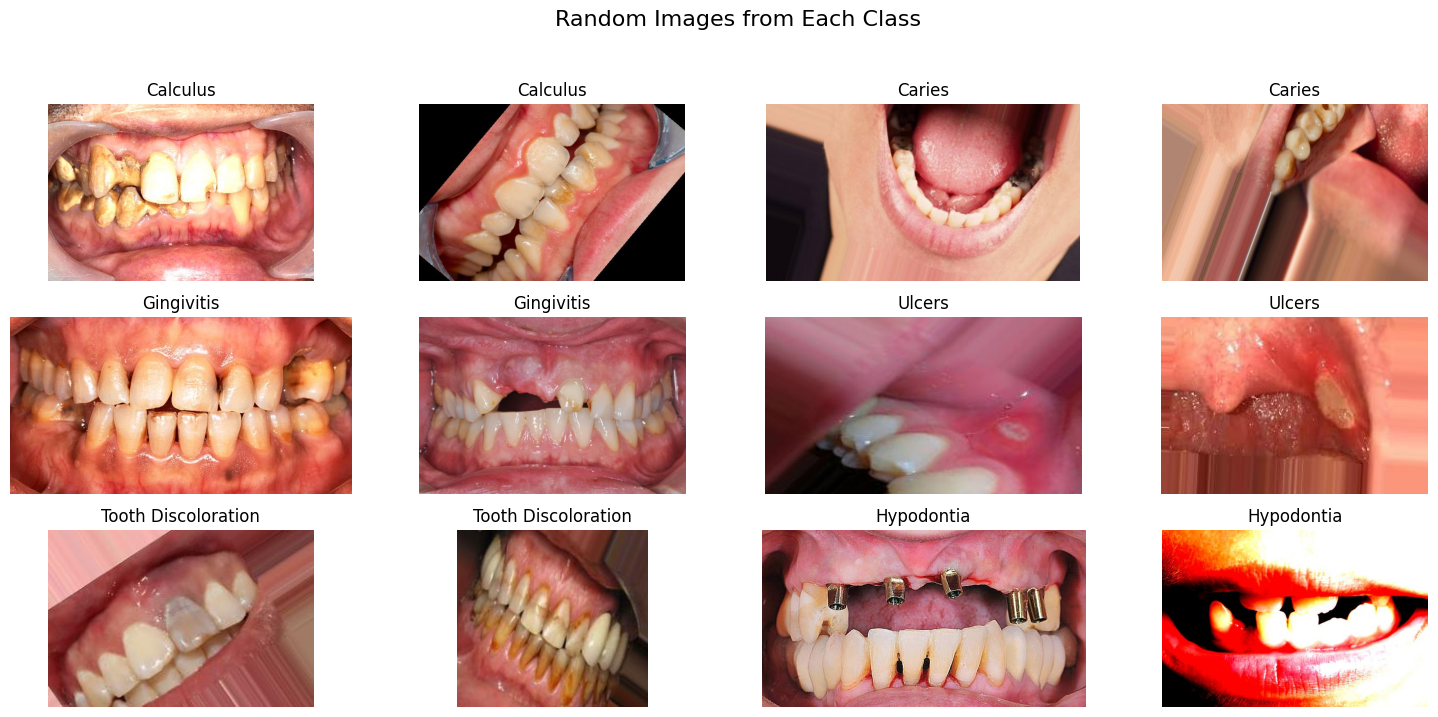

In [3]:
# Number of images to display per class and per row
num_images_per_class = 2
num_images_per_row = 4

# Set seed for reproducibility
random.seed(42)

# Function to get random images from a directory
def get_random_images_from_dir(directory, num_images):
    all_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)

# Create a figure
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Random Images from Each Class', fontsize=16)

# Flatten axs array for easier indexing
axs = axs.flatten()

# Iterate through classes and display images
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)
    
    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1

# Hide any unused subplots
for i in range(image_idx, len(axs)):
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Data Visualization - Bar Plot

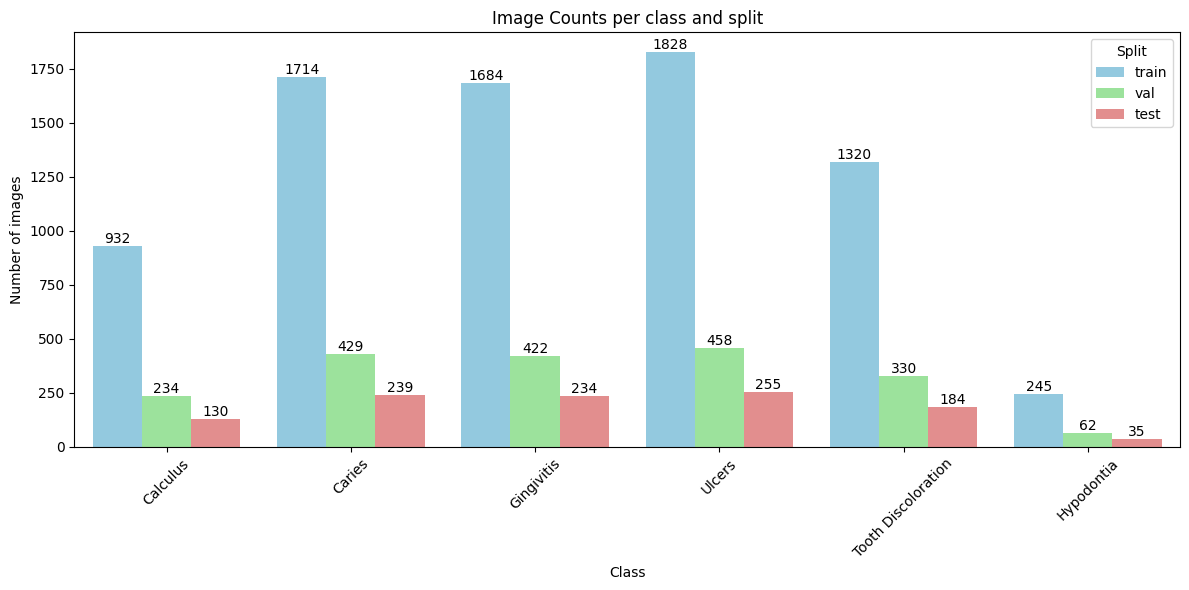

In [4]:
# Define the base directory and classes
base_dir = '/kaggle/working/dataset'
classes = ['Calculus', 'Caries', 'Gingivitis', 'Ulcers', 'Tooth Discoloration', 'Hypodontia']

# Initialize a list to hold tne counts
data = []
# Counts images for each class and split 
for class_name in classes:
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        num_images = len(os.listdir(split_dir))
        data.append({'Class': class_name, 'Split' : split, 'Count' : num_images})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Create a grouped bar chart 
plt.figure(figsize = (12,6))
ax = sns.barplot(x='Class', y='Count', hue='Split', data=df, palette=['skyblue', 'lightgreen', 'lightcoral'])

# Add count numbers on top of each bar 
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() /2., p.get_height()),
    ha = 'center', va = 'center',
    fontsize = 10, color='black',
    xytext = (0,5), textcoords='offset points')


# Customize the plot 
plt.title('Image Counts per class and split')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(rotation=45)
plt.legend(title='Split')

# show the plot 
plt.tight_layout()
plt.show()

## Model Preparing and Training 

In [5]:
# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
image_size = (128, 128)
batch_size = 16
num_epochs = 50


# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Normalization for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# Get number of classes
num_classes = len(train_dataset.classes)

# Use a smaller model - ResNet18
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = resnet18(weights=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = CustomModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.3MB/s]


In [7]:
# Set environment variable to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
early_stopping = True
patience = 3  # Number of epochs to wait if no improvement is observed

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Initialize lists to store losses, accuracies, and learning rates
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variables to store y_true and y_scores for precision-recall calculation
y_true = []
y_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    val_outputs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            val_outputs.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Append true labels and predicted scores for precision-recall calculation
    y_true.extend(val_true)
    y_scores.extend(val_outputs)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model checkpoint here if you want

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            early_stop = True
            break

    # LR scheduler step based on validation loss
    scheduler.step(val_loss)

    if early_stop:
        break

Epoch [1/50], Train Loss: 0.9369, Val Loss: 0.7039, Val Acc: 0.7199
Epoch [2/50], Train Loss: 0.6498, Val Loss: 0.6250, Val Acc: 0.7406
Epoch [3/50], Train Loss: 0.5292, Val Loss: 0.5580, Val Acc: 0.7788
Epoch [4/50], Train Loss: 0.4783, Val Loss: 0.6099, Val Acc: 0.7726
Epoch [5/50], Train Loss: 0.4214, Val Loss: 0.4590, Val Acc: 0.8227
Epoch [6/50], Train Loss: 0.3783, Val Loss: 0.3059, Val Acc: 0.8713
Epoch [7/50], Train Loss: 0.3215, Val Loss: 0.3846, Val Acc: 0.8372
Epoch [8/50], Train Loss: 0.3194, Val Loss: 0.4012, Val Acc: 0.8475
Epoch [9/50], Train Loss: 0.2936, Val Loss: 0.2895, Val Acc: 0.8811
Epoch [10/50], Train Loss: 0.2664, Val Loss: 0.2866, Val Acc: 0.8739
Epoch [11/50], Train Loss: 0.2894, Val Loss: 0.2682, Val Acc: 0.8770
Epoch [12/50], Train Loss: 0.2415, Val Loss: 0.2960, Val Acc: 0.8703
Epoch [13/50], Train Loss: 0.2310, Val Loss: 0.2717, Val Acc: 0.8889
Epoch [14/50], Train Loss: 0.2203, Val Loss: 0.3054, Val Acc: 0.8646
Early stopping after 14 epochs.


## Model Evaluation

In [8]:
# Test the model
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8784


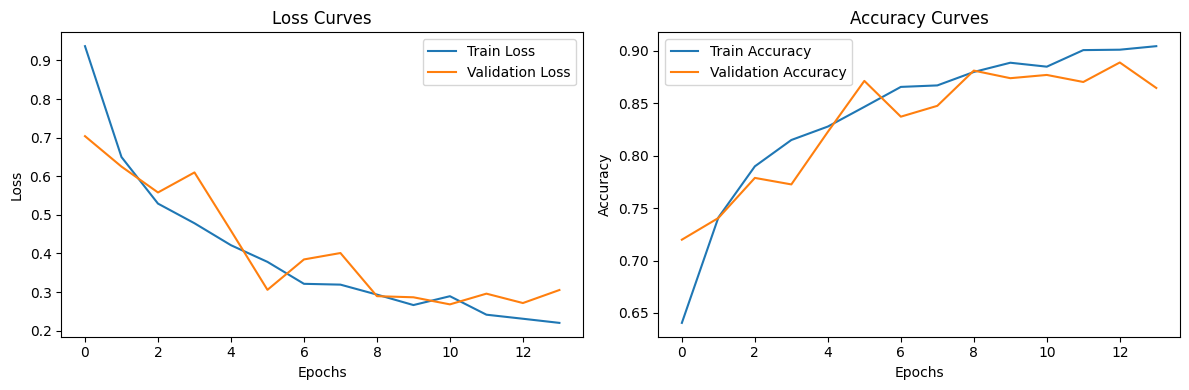

In [9]:
# Plotting loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
# Generate classification report
class_names = test_dataset.classes
report = classification_report(test_true, test_preds, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.64      0.84      0.72       130
             Caries       0.89      0.94      0.92       239
         Gingivitis       0.89      0.74      0.81       234
         Hypodontia       0.97      0.91      0.94        35
Tooth Discoloration       0.96      0.89      0.92       184
             Ulcers       0.95      0.96      0.95       255

           accuracy                           0.88      1077
          macro avg       0.88      0.88      0.88      1077
       weighted avg       0.89      0.88      0.88      1077



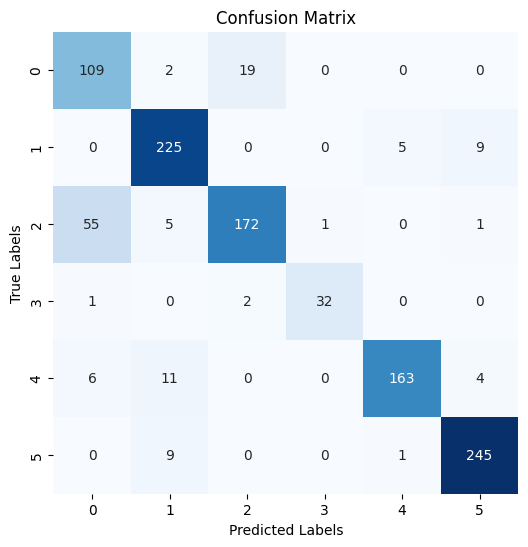

In [11]:
# Get predictions for the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()